In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

In [2]:
def TDT(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    if b == 0 and c == 0:
        return 0
    else:
        return (b-c)**2/(b+c)

In [3]:
# SHD [Yamamoto and Shibuya, PSB 2022]

def SHD(cc, n):
    T = TDT(n)
    
    d = np.zeros(2)
    N = np.zeros(6)
    
    for k in range(6):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0:
                N[4] -= 1
            elif N[1] > 0:
                N[1] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[0] -= 1
            N[3] += 1
            
            T = TDT(N)
            d[0] -= 1
        
        T = TDT(n)
        for k in range(6):
            N[k] = n[k]
        
        while T < cc:
            if N[3] > 0:
                N[3] -= 1
            elif N[0] > 0:
                N[0] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[1] -= 1
            N[4] += 1
            
            T = TDT(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
    
    else:
        step = 0
        
        if n[0] + 2*n[3] > n[1] + 2*n[4]:
            while T >= cc:
                if n[3] > 0:
                    n[3] -= 1
                elif n[0] > 0:
                    n[0] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[1] -= 1
                n[4] += 1
            
                T = TDT(n)
                step += 1
        else:
            while T >= cc:
                if n[4] > 0:
                    n[4] -= 1
                elif n[1] > 0:
                    n[1] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[0] -= 1
                n[3] += 1
            
                T = TDT(n)
                step += 1
        
        return step-1

In [4]:
# pseudo_SHD

def pseudo_SHD(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    return math.fabs(b-c)/4

In [5]:
# exponential mechanism

def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(score, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    s = np.zeros(m)
    for i in range(m):
        s[i] = score[i]
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * s[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        s[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [6]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [7]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/6)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/5)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/3)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/2)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/4)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/8)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/2)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/3)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    return n

In [8]:
def evaluation(K, N, M):
    RankError = np.zeros((7,3))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    re = np.zeros((7,3))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = TDT(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            k = [int(n[a][0]), int(n[a][1]), int(n[a][2]), int(n[a][3]), int(n[a][4]), int(n[a][5])]
            PSEUDO[i] = pseudo_SHD(k)
            EXACT[i] = SHD(cc,k)
        
        #print(simple_shd)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                shdExp_result = exp_mec(shd,M,K,i+3.2)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+3.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.2)
            if K == 5:
                shdExp_result = exp_mec(shd,M,K,i+2.2)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+2.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.2)
            if K == 3:
                shdExp_result = exp_mec(shd,M,K,i+1.4)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+1.4)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.4)
            if K == 1:
                shdExp_result = exp_mec(shd,M,K,i+0.7)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+0.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+0.7)
            re[i][0] += sum(shdExp_result)-(K-1)*K/2
            re[i][1] += sum(pseudoExp_result)-(K-1)*K/2
            re[i][2] += sum(JointPnF_result)-(K-1)*K/2
                
    RankError = re/(50*K)
    return RankError

[[1.58 1.02 1.24]
 [0.42 0.78 0.38]
 [0.28 0.46 0.2 ]
 [0.3  0.26 0.26]
 [0.14 0.28 0.28]
 [0.24 0.18 0.18]
 [0.1  0.2  0.22]]
[[1.4  0.92 0.94]
 [0.46 0.48 0.4 ]
 [0.24 0.26 0.16]
 [0.24 0.24 0.2 ]
 [0.14 0.22 0.16]
 [0.14 0.12 0.14]
 [0.12 0.16 0.18]]
[[1.44 0.96 1.22]
 [0.52 0.38 0.36]
 [0.12 0.24 0.12]
 [0.1  0.14 0.12]
 [0.08 0.14 0.08]
 [0.12 0.08 0.1 ]
 [0.04 0.06 0.1 ]]
[[1.4  1.5  1.66]
 [0.32 0.46 0.42]
 [0.26 0.22 0.24]
 [0.1  0.14 0.24]
 [0.18 0.22 0.2 ]
 [0.16 0.18 0.2 ]
 [0.04 0.22 0.16]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1.22 1.94 0.82]
 [0.28 0.34 0.26]
 [0.12 0.22 0.24]
 [0.22 0.22 0.1 ]
 [0.18 0.24 0.12]
 [0.16 0.16 0.16]
 [0.08 0.06 0.14]]
[[1.408 1.268 1.176]
 [0.4   0.488 0.364]
 [0.204 0.28  0.192]
 [0.192 0.2   0.184]
 [0.144 0.22  0.168]
 [0.164 0.144 0.156]
 [0.076 0.14  0.16 ]]


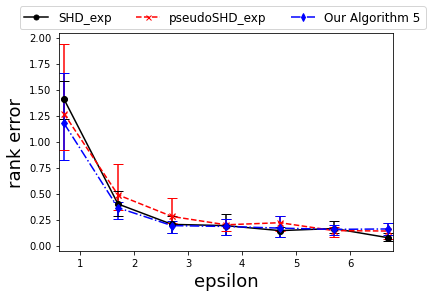

In [9]:
# n = 150, M = 5000
# K = 1

RE = np.zeros((7,3))
max_RE = np.zeros((7,3)); min_RE = np.ones((7,3))*5000
sum_RE = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    RE = evaluation(1,150,5000)
    for i in range(7):
        epsilon[i] = i+0.7
        for k in range(3):
            if RE[i][k] > max_RE[i][k]:
                max_RE[i][k] = RE[i][k]
            if RE[i][k] < min_RE[i][k]:
                min_RE[i][k] = RE[i][k]
            sum_RE[i][k] += RE[i][k]
    print(RE)
RE = sum_RE/5

for k in range(3):
    y_err[0,:,k] = RE[:,k] - min_RE[:,k]
    y_err[1,:,k] = max_RE[:,k] - RE[:,k]

print(RE)
fig = plt.figure()
plt.ylim(-0.05, max(max(max_RE[:,0]),max(max_RE[:,1]),max(max_RE[:,2]))+0.1)
plt.xlim(0.6, 6.8)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RankError_TDT_K=1.png")
fig.savefig("figs/RankError_TDT_K=1.eps")